# PySmorch: A Custom Neural Network Framework

**Author: Yanjie Chen**

PySmorch is a custom-built neural network framework implemented from scratch using NumPy. This project demonstrates the fundamental concepts of deep learning by implementing core neural network components including forward and backward propagation algorithms.

## Project Overview

This implementation includes:

### Core Neural Network Components
- **Linear Layer**: Fully connected layer with weight matrix multiplication
- **ReLU Activation**: Non-linear activation function with proper gradient computation  
- **Bias Layer**: Trainable bias parameters for each neuron
- **Cross-Entropy Loss**: Softmax-based loss function for multi-class classification

### Key Features
- **Gradient Checking**: Numerical gradient verification for all implemented layers
- **Modular Design**: Layer-based architecture allowing flexible network composition
- **Backpropagation**: Complete backward pass implementation for all layers
- **CIFAR-10 Classification**: Practical application comparing different CNN architectures

### Implementations Included
1. **PySmorch Framework**: Custom neural network library with gradient computation
2. **CNN Architectures**: Simple ConvNet and ResNet32 implementations using PyTorch
3. **Performance Comparison**: Evaluation of different model sizes and data augmentation effects
4. **Training Pipeline**: Complete training and evaluation framework with visualization

The project showcases both theoretical understanding through the custom framework implementation and practical application through modern CNN architectures on the CIFAR-10 dataset.

In [2]:
from math import sqrt
from scipy.signal import convolve2d
import numpy as np
from numpy.linalg import norm
from numpy.random import randn, normal, randint
import urllib
import matplotlib.pyplot as plt
np.random.seed(0)
def good_job(path):
    a = plt.imread(urllib.request.urlopen(path),'r')
    fig = plt.imshow(a)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

# Gradient checking utility function
def check_gradient(f, grad, x):
    y = normal(size=x.shape)
    y = y/norm(y)*norm(x)

    g = grad(x)
    rel_error = np.zeros(10)
    for iter in range(10):
        y = y/10
        d1 = f(x + y) - f(x)  # exact change in function
        d2 = np.sum((g * y).ravel())  # approximate change from gradient
        rel_error[iter] = (d1-d2)/d1
        #print('d1=%1.5g, d2=%1.5g, error=%1.5g,'%(d1,d2, rel_error[iter] ))
    min_error = min(np.abs(rel_error))
    print('Min relative error = %1.5g'%min_error)
    did_pass = min_error < 1e-6
    print(did_pass and "Test passed" or "Test failed")
    return min_error < 1e-6


## Core Framework Components

The PySmorch framework consists of modular neural network components that can be composed together to build complex architectures.

### Data Layer
The data input layer stores training data arrays. During forward pass, it passes data to the next layer. During backward pass, it performs no operations since it contains no trainable parameters.

### Square Loss Layer
Implements least-squares loss function: $\frac{1}{2M}\|X-Y\|^2$ where $Y$ represents target labels and $M$ is the number of training samples. The backward pass computes gradients with respect to inputs and propagates them to previous layers.

The following implementations demonstrate the basic structure of PySmorch layers:

In [3]:
# Base layer implementations
class Data:
    """Stores an input array of training data, and hands it to the next layer."""
    def __init__(self, data):
        self.data = data
        self.out_dims = data.shape
    def set_data(self, data):
        self.data = data
    def forward(self):
        return self.data
    def backward(self, dwnstrm):
        pass

class SquareLoss:
    """Given a matrix of logits (one logit vector per row), and a vector labels,
    compute the sum of squares difference between the two"""
    def __init__(self, in_layer, labels):
        self.in_layer = in_layer
        self.labels = labels
    def set_data(self, labels):
        self.labels[:] = labels
    def forward(self):
        """Loss value is (1/2M) || X-Y ||^2"""
        self.in_array = self.in_layer.forward()
        self.num_data = self.in_array.shape[0]
        return (0.5/self.num_data) * norm(self.in_array-self.labels)**2

    def backward(self):
        """Gradient is (1/M) (X-Y), where N is the number of training samples"""
        self.pass_back = (self.in_array-self.labels)/self.num_data
        self.in_layer.backward(self.pass_back) # hand the gradient of loss with respect to inputs back to previous layer


### Gradient Verification Test

Testing the square loss implementation with numerical gradient checking:

In [4]:
# Create a random test problem
X = Data(randn(10,3))
Y = randn(10,3)
# Create a square loss layer that accepts the X's, and compares them to the Y's.
# This is basically a neural net that does nothing but compute a loss.
loss = SquareLoss(X,Y)
# Create functions to produce the loss, and its gradient
def network_loss(Xdata):
    X.set_data(Xdata)
    return loss.forward()
def loss_grad(Xdata):
    X.set_data(Xdata)
    loss.forward()
    loss.backward()
    return loss.pass_back
did_pass = check_gradient(network_loss,loss_grad,randn(10,3))
assert did_pass, "Square loss gradient verification failed!"
print("Square loss gradient test passed successfully.")

Min relative error = 1.5056e-07
Test passed
Square loss gradient test passed successfully.


## Linear Layer Implementation

The linear layer performs matrix multiplication $XW$ where $X$ is the input and $W$ is the weight matrix. During backpropagation, it computes:
1. Gradient with respect to weights $W$ (stored in `self.G`)
2. Gradient with respect to inputs (passed to previous layer)

In [5]:
class Linear:
    """Given an input matrix X, with one feature vector per row,
    this layer computes XW, where W is a linear operator."""
    def __init__(self, in_layer, num_out_features):
        assert len(in_layer.out_dims)==2, "Input layer must contain a list of 1D linear feature data."
        self.in_layer = in_layer
        num_data, num_in_features = in_layer.out_dims
        self.out_dims = np.array([num_data, num_out_features])
        # Declare the weight matrix
        self.W = randn(num_in_features, num_out_features)/sqrt(num_in_features)
    def forward(self):
        """This function computes XW"""
        self.in_array = self.in_layer.forward()
        return self.in_array @ self.W
    def backward(self, dwnstrm):
        # Compute the gradient of the loss with respect to W, and store it as G
        self.G = self.in_array.T @ dwnstrm
        # Compute grad of loss with respect to inputs, and hand this gradient backward to the layer behind
        input_grad = dwnstrm @ self.W.T
        self.in_layer.backward(input_grad)

### Linear Layer Gradient Testing

In [ ]:
# Test linear layer gradients
# Make a random dataset with 10 samples of 3 features each
X = Data(randn(10,3))
Y = randn(10,2)            # The label vector has to entries per sample
L1 = Linear(X,num_out_features=4)  # A linear layer maps each 3-vector onto a 2-vector
L2 = Linear(L1,num_out_features=2)  # A linear layer maps each 3-vector onto a 2-vector
loss = SquareLoss(L2,Y)    # Loss compares the output of the linear layer to the labels
# Check the gradient for W
def network_loss(W): # Computes the value of the loss function
    L2.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L2_grad(W):      # Gradient of loss function with respect to weights in linear layer
    L2.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L2.G
W = normal(size=L2.W.shape)
did_pass = check_gradient(network_loss,L2_grad,W)
assert did_pass, "Linear layer weight gradient verification failed."

# Check that the correct gradient is passed back
def network_loss(W): # Computes the value of the loss function
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L1_grad(W):      # Gradient of loss function with respect to weights in linear layer
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Linear layer input gradient verification failed."
print("Linear layer gradient tests passed successfully.")

Min relative error = 9.7564e-09
Test passed
Min relative error = 1.4823e-07
Test passed
Linear layer gradient tests passed successfully.


## ReLU Activation Layer

Neural networks require non-linear activation functions to learn complex patterns. Without non-linearities, multiple linear layers would be equivalent to a single linear transformation. The ReLU (Rectified Linear Unit) activation function applies element-wise maximum operation: $\max(x, 0)$.

In [7]:
class Relu:
    """Given an input matrix X, with one feature vector per row,
    this layer computes maximum(X,0), where the maximum operator is coordinate-wise."""
    def __init__(self, in_layer):
        self.in_layer = in_layer
        self.in_dims = in_layer.out_dims
        self.out_dims = self.in_dims
    def forward(self):
        self.in_array = self.in_layer.forward()
        return np.maximum(self.in_array, 0)
    def backward(self, dwnstrm):
        mask = (self.in_array > 0).astype(self.in_array.dtype)
        input_grad = dwnstrm * mask
        self.in_layer.backward(input_grad)

### ReLU Layer Testing

In [8]:
# Test ReLU layer gradients
# Create a dataset
X = Data(randn(10,3))
Y = randn(10,1)
# Create network with 2 linear layers and a Relu in the middle
L1 = Linear(X,5)
R1 = Relu(L1)
L2 = Linear(R1,1)
loss = SquareLoss(L2,Y)
# Methods to compute loss function, and gradient of loss with respect to L1 parameters.  This gradient has to
# backprop through your Relu, so this test should fail if your Relu is messed up.
def network_loss(W):
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L1_grad(W):
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "ReLU layer gradient verification failed!"
print("ReLU layer gradient test passed successfully.")

Min relative error = 1.9584e-07
Test passed
ReLU layer gradient test passed successfully.


## Cross-Entropy Loss Layer

For classification tasks, cross-entropy loss is more appropriate than least-squares loss. Given input logits $x$ and true class $k$, cross-entropy is computed as:

$$- \log\left(  \frac{\exp(x_k)} { \sum_i \exp(x_i) }   \right) = -x_k + \log( \sum_i \exp(x_i))$$

**Implementation Note**: To maintain numerical stability, the implementation uses log-sum-exp trick by subtracting the maximum value before exponentiation, preventing overflow from exponentiating large positive numbers.


In [10]:
class CrossEntropy:
    """Given a matrix of logits (one logit vector per row), and a vector labels,
    compute the cross entropy of the softmax.
    The labels must be a 1d vector"""
    def __init__(self, in_layer, ones_hot):
        self.in_layer = in_layer
        self.ones_hot = ones_hot
    def set_labels(self, ones_hot):
        self.ones_hot = ones_hot
    def forward(self):
        in_array = self.in_layer.forward()
        self.num_data = in_array.shape[0]

        shifted_logits = in_array - np.max(in_array, axis=1, keepdims=True)
        exp_scores = np.exp(shifted_logits)
        self.p = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        cross_entropy = -np.sum(self.ones_hot * np.log(self.p + 1e-12)) / self.num_data
        return cross_entropy

    def backward(self):
        dX = (self.p - self.ones_hot) / self.num_data
        self.in_layer.backward(dX)


### Cross-Entropy Layer Testing

In [11]:
# Test cross-entropy layer gradients and numerical stability
## Make dataset
X = Data(randn(10,3))    # Create 10 random feature vectors of length 3
Y = randint(5,size=(10)) # Assign a random class to each vector
Y = np.eye(5)[Y]         # Convert the 1D label vector to a 2D one's hot encoding with a 5-entry row for each sample
# Build neural net with a linear layer, Relu, and a cross entropy loss
L1 = Linear(X,5)
R1 = Relu(L1)
loss = CrossEntropy(R1,Y)
# Build methods to get loss and gradient
def network_loss(W):
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L1_grad(W):
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
print('Checking the gradient...')
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Cross-entropy gradient verification failed!"
print('    Passed')
print('Checking that your method is stable with large inputs.')
L1.W = normal(size=L1.W.shape)*1000
l = loss.forward()
assert np.isfinite(l), "Cross-entropy implementation is numerically unstable!"
print('    Passed')
print("Cross-entropy layer tests passed successfully!")

Checking the gradient...
Min relative error = 5.0684e-10
Test passed
    Passed
Checking that your method is stable with large inputs.
    Passed
Cross-entropy layer tests passed successfully!


## Bias Layer Implementation

Neural network neurons typically compute $xw + b$ where $b$ is a trainable bias term. The bias layer adds a learnable constant to each feature, enabling the network to shift activation functions and improve learning capacity.

In [12]:
class Bias:
    """Given an input matrix X, add a trainable constant to each entry."""
    def __init__(self, in_layer):
        self.in_layer = in_layer
        num_data, num_in_features = in_layer.out_dims
        self.out_dims = in_layer.out_dims
        # Declare the weight matrix
        self.W = randn(1,num_in_features)
    def forward(self):
        self.in_array = self.in_layer.forward()
        return self.in_array + self.W

    def backward(self, dwnstrm):
        # Compute the gradient of the loss with respect to W, and store it as G
        self.G = np.sum(dwnstrm, axis=0, keepdims=True)
        # Compute grad of loss with respect to inputs, and hand this gradient backward to the layer behind
        self.in_layer.backward(dwnstrm)

### Bias Layer Testing

In [13]:
# Test bias layer gradients
# Create a dataset
X = Data(randn(10,3))
Y = randn(10,1)
# Create network with 2 linear layers and a Relu in the middle
L1 = Linear(X,5)
B1 = Bias(L1)
R1 = Relu(B1)
L2 = Linear(R1,1)
loss = SquareLoss(L2,Y)
# Build methods to get loss and gradient
def network_loss(W):
    B1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def B1_grad(W):
    B1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return B1.G
W = normal(size=B1.W.shape)
did_pass = check_gradient(network_loss,B1_grad,W)
assert did_pass, "Bias layer weight gradient verification failed!"
def network_loss(W):
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L1_grad(W):
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Bias layer input gradient verification failed!"
print("Bias layer gradient tests passed successfully.")

Min relative error = 3.4919e-08
Test passed
Min relative error = 2.4635e-08
Test passed
Bias layer gradient tests passed successfully.


## Complete Network Testing

Testing a full neural network with multiple linear layers, ReLU activations, bias terms, and cross-entropy loss:

In [14]:
# Test complete neural network with all components
## Make dataset
X = Data(randn(10,3))    # Create 10 random feature vectors of length 3
Y = randint(5,size=(10)) # Assign a random class to each vector
Y = np.eye(5)[Y]         # Convert the 1D label vector to a 2D one's hot encoding with a 5-entry row for each sample

# Create network with 3 linear layers, biases, and Relu
L1 = Linear(X,5)
B1 = Bias(L1)
R1 = Relu(B1)
L2 = Linear(R1,8)
B2 = Bias(L2)
R2 = Relu(B2)
L3 = Linear(R2,5)
B3 = Bias(L3)
loss = CrossEntropy(B3,Y)

def network_loss(W):
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value

def L1_grad(W):
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Complete network gradient verification failed!"
print("Complete neural network test passed successfully!")


Min relative error = 6.7547e-08
Test passed
Complete neural network test passed successfully!


---

## Part II: Convolutional Neural Networks with PyTorch

Having implemented the core components of neural networks from scratch, we now move to practical applications using modern deep learning frameworks. This section demonstrates CNN architectures for image classification on the CIFAR-10 dataset.

### CIFAR-10 Dataset and Preprocessing

100%|██████████| 170M/170M [00:02<00:00, 60.0MB/s] 


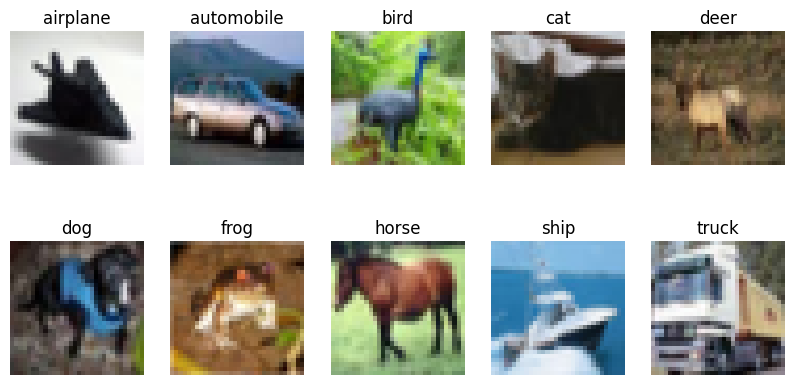

Training set mean per channel: [0.49139968 0.48215841 0.44653091]
Training set std  per channel: [0.24703223 0.24348513 0.26158784]


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import random

# ================================================
# 1. Create a transform to convert data to tensors
# ================================================
initial_transform = transforms.ToTensor()

# ================================================
# 2. Instantiate the CIFAR-10 dataset
# ================================================
train_dataset_raw = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=initial_transform
)

test_dataset_raw = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=initial_transform
)

# categories of CIFAR-10
classes = train_dataset_raw.classes

# visualize the first image for each class
class_found_index = {}
for idx, (img, label) in enumerate(train_dataset_raw):
    if label not in class_found_index:
        class_found_index[label] = idx
    if len(class_found_index) == len(classes):
        break

plt.figure(figsize=(10, 5))
for class_idx, data_idx in class_found_index.items():
    img, label = train_dataset_raw[data_idx]
    img_np = np.transpose(img.numpy(), (1, 2, 0))

    plt.subplot(2, 5, class_idx + 1)
    plt.imshow(img_np)
    plt.title(classes[label])
    plt.axis('off')
plt.show()

# compute the normalization statistics
train_data_array = train_dataset_raw.data.astype(float) / 255.0
mean_per_channel = train_data_array.mean(axis=(0, 1, 2))
std_per_channel = train_data_array.std(axis=(0, 1, 2))

print("Training set mean per channel:", mean_per_channel)
print("Training set std  per channel:", std_per_channel)

# transform to and normalize the data
transform_with_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_per_channel, std=std_per_channel)
])

# apply new transform to the dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_with_norm
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_with_norm
)

# ================================================
# 3. Create data loaders
# ================================================
batch_size = 128

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [2]:
# ================================================
# 4. Build the models
# ================================================

# simple convnet with 3 conv layers
class SimpleConvNet(nn.Module):
    def __init__(self, initial_channels=16, num_classes=10):
        super(SimpleConvNet, self).__init__()
        # first  conv: input = 3,                    output = initial_channels
        self.conv1 = nn.Conv2d(3, initial_channels, kernel_size=3, padding=1)
        # second conv: input = initial_channels,     output = initial_channels * 2
        self.conv2 = nn.Conv2d(initial_channels, initial_channels*2, kernel_size=3, padding=1)
        # third  conv: input = initial_channels * 2, output = initial_channels * 4
        self.conv3 = nn.Conv2d(initial_channels*2, initial_channels*4, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d(1) 
        self.fc = nn.Linear(initial_channels*4, num_classes)

    def forward(self, x):
        # first layer
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # second layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # third layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # global average pooling
        x = self.global_pool(x)     # B,C,1,1
        x = torch.flatten(x, 1)     # B,C
        out = self.fc(x)            # B,10
        return out


# implement ResNet-32
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, 
                     padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, 
                     bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes*self.expansion:
            self.shortcut = nn.Sequential(
                conv1x1(in_planes, planes*self.expansion, stride),
                nn.BatchNorm2d(planes*self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetCIFAR(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetCIFAR, self).__init__()
        self.in_planes = 16
        self.conv1 = conv3x3(3, 16)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self._make_layer(block, 16,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32,  num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64,  num_blocks[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64*block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.in_planes, planes, stride=stride))
        self.in_planes = planes * block.expansion
        for i in range(1, num_blocks):
            layers.append(block(self.in_planes, planes, stride=1))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) 
        out = self.layer1(out)                
        out = self.layer2(out)                
        out = self.layer3(out)                
        out = self.avgpool(out)               
        out = out.view(out.size(0), -1)       
        out = self.fc(out)                    
        return out

def ResNet32():
    return ResNetCIFAR(BasicBlock, [5, 5, 5])


# Instantiate the models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_small = SimpleConvNet(initial_channels=16).to(device)
model_large = SimpleConvNet(initial_channels=64).to(device)
model_resnet = ResNet32().to(device)

# ================================================
# 5. Instantiate the cross-entropy loss function
# ================================================
criterion = nn.CrossEntropyLoss()

# ================================================
# 6. Instantiate the SGD optimizer
# ================================================
optimizer_small  = optim.SGD(model_small.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer_large  = optim.SGD(model_large.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# ================================================
# 7. Applying cosine annealing learning rate scheduler
# ================================================
scheduler_small  = CosineAnnealingLR(optimizer_small, T_max=100)
scheduler_large  = CosineAnnealingLR(optimizer_large, T_max=100)
scheduler_resnet = CosineAnnealingLR(optimizer_resnet, T_max=100)

# ================================================
# 8. Move model to GPU
# ================================================

# already done above when we instantiated the models

# ================================================
# 9. Training loop
# ================================================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # update statistics
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        running_correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * running_correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            running_correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * running_correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, test_loader, 
                criterion, device, num_epochs=100, 
                lr=0.1, momentum=0.9, weight_decay=5e-4):
    """
    train the model, and return the train/test loss/acc for each epoch
    """
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    # record the process
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        scheduler.step()  # update the learning rate

        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        
    return history


# ================================================
# 10. Train the 3 models for 100 epochs
# ================================================

print("\n--- Training SimpleConvNet-small ---")
hist_small = train_model(model_small, train_loader, test_loader, criterion, device, num_epochs = 100)

print("\n--- Training SimpleConvNet-large ---")
hist_large = train_model(model_large, train_loader, test_loader, criterion, device, num_epochs = 100)

print("\n--- Training ResNet32 ---")
hist_resnet = train_model(model_resnet, train_loader, test_loader, criterion, device, num_epochs = 100)


Using device: cuda

--- Training SimpleConvNet-small ---
Epoch [1/100] Train Loss: 1.7456, Train Acc: 35.04% | Test Loss: 1.4320, Test Acc: 47.55%
Epoch [2/100] Train Loss: 1.3445, Train Acc: 51.24% | Test Loss: 1.2354, Test Acc: 56.07%
Epoch [3/100] Train Loss: 1.1975, Train Acc: 57.27% | Test Loss: 1.2070, Test Acc: 56.50%
Epoch [4/100] Train Loss: 1.0932, Train Acc: 61.36% | Test Loss: 1.0893, Test Acc: 62.01%
Epoch [5/100] Train Loss: 1.0328, Train Acc: 63.74% | Test Loss: 1.0281, Test Acc: 64.24%
Epoch [6/100] Train Loss: 0.9884, Train Acc: 65.11% | Test Loss: 1.0012, Test Acc: 65.22%
Epoch [7/100] Train Loss: 0.9390, Train Acc: 67.02% | Test Loss: 0.9312, Test Acc: 67.80%
Epoch [8/100] Train Loss: 0.9061, Train Acc: 68.00% | Test Loss: 0.9845, Test Acc: 65.78%
Epoch [9/100] Train Loss: 0.8869, Train Acc: 69.02% | Test Loss: 0.9622, Test Acc: 66.79%
Epoch [10/100] Train Loss: 0.8743, Train Acc: 69.49% | Test Loss: 0.8876, Test Acc: 69.57%
Epoch [11/100] Train Loss: 0.8484, Train A

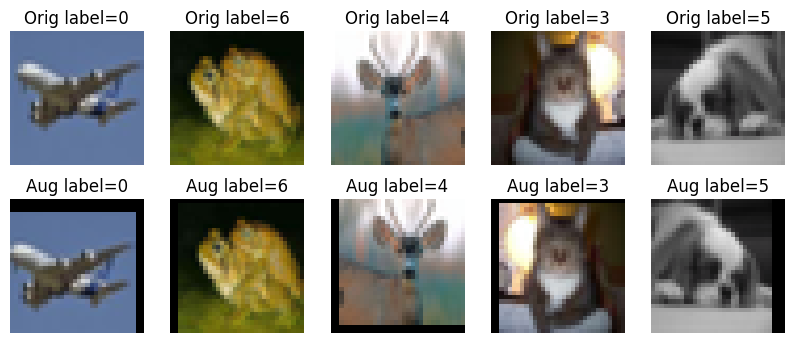


--- Training SimpleConvNet-small (with augmentation) ---
Epoch [1/100] Train Loss: 1.8158, Train Acc: 31.61% | Test Loss: 1.5258, Test Acc: 43.83%
Epoch [2/100] Train Loss: 1.4371, Train Acc: 47.77% | Test Loss: 1.3783, Test Acc: 51.01%
Epoch [3/100] Train Loss: 1.2976, Train Acc: 53.39% | Test Loss: 1.2327, Test Acc: 56.01%
Epoch [4/100] Train Loss: 1.2166, Train Acc: 56.59% | Test Loss: 1.2180, Test Acc: 56.96%
Epoch [5/100] Train Loss: 1.1636, Train Acc: 58.69% | Test Loss: 1.1075, Test Acc: 61.16%
Epoch [6/100] Train Loss: 1.1261, Train Acc: 60.25% | Test Loss: 1.1554, Test Acc: 59.21%
Epoch [7/100] Train Loss: 1.0928, Train Acc: 61.59% | Test Loss: 1.0860, Test Acc: 62.08%
Epoch [8/100] Train Loss: 1.0629, Train Acc: 62.87% | Test Loss: 1.0422, Test Acc: 63.07%
Epoch [9/100] Train Loss: 1.0324, Train Acc: 63.86% | Test Loss: 1.0901, Test Acc: 62.22%
Epoch [10/100] Train Loss: 1.0164, Train Acc: 64.67% | Test Loss: 1.0171, Test Acc: 64.85%
Epoch [11/100] Train Loss: 0.9968, Train 

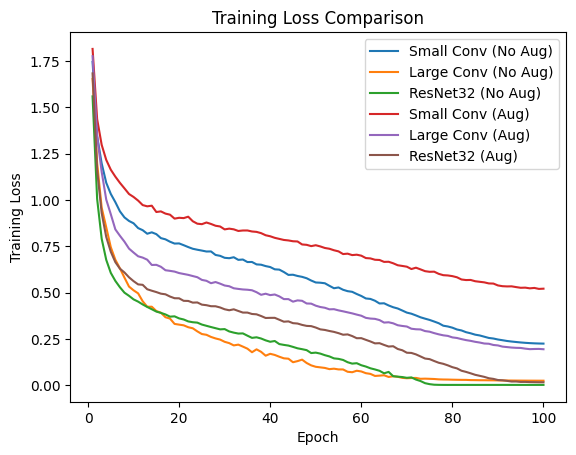

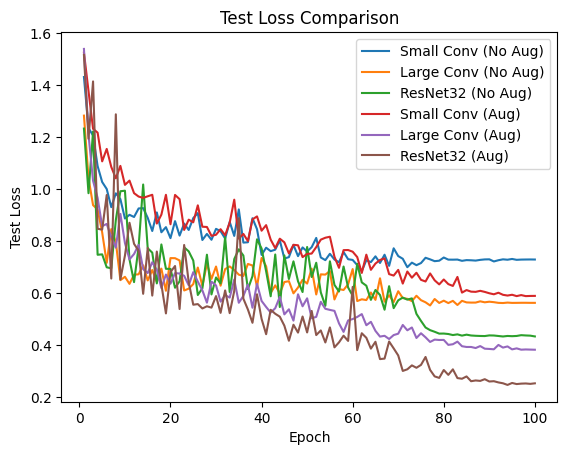

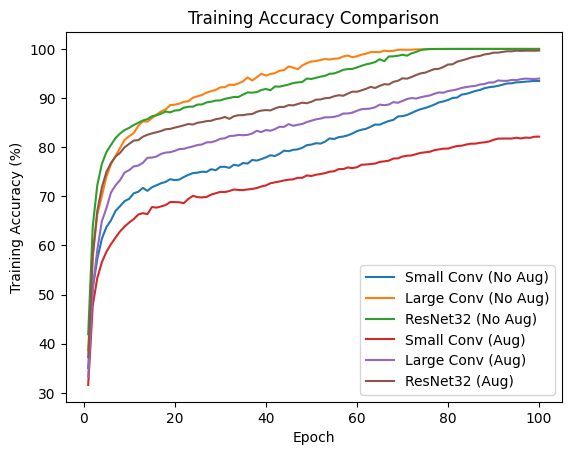

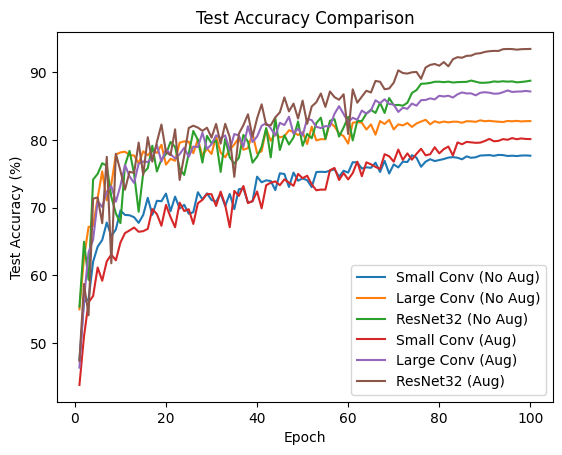

In [3]:
# ================================================
# 11. Augmentation
# ================================================
transform_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_per_channel, std=std_per_channel)
])

# augumented training set
train_dataset_aug = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_aug
)

train_loader_aug = DataLoader(
    dataset=train_dataset_aug,
    batch_size=batch_size,
    shuffle=True
)

# visualize the augumented images

def visualize_augmentation(n=5):
    # choose images randomly
    indices = random.sample(range(len(train_dataset)), n)
    fig = plt.figure(figsize=(10, 4))
    
    for i, idx in enumerate(indices):
        original_img, label = train_dataset[idx]
        
        # get original image
        pil_img = train_dataset.data[idx]
        pil_img = torchvision.transforms.functional.to_pil_image(pil_img)
        aug_img = transform_aug(pil_img)  # get the augmented image
        
        # denormalize the images
        def denormalize(img_tensor):
            # img_tensor: C,H,W
            img_tensor = img_tensor.clone().detach().cpu()
            for c in range(3):
                img_tensor[c] = img_tensor[c] * std_per_channel[c] + mean_per_channel[c]
            # clip to valid range
            img_tensor = torch.clamp(img_tensor, 0, 1)
            return img_tensor.numpy().transpose(1, 2, 0)  # (H,W,C)
        
        orig_np = denormalize(original_img)
        aug_np = denormalize(aug_img)
        
        # plot
        ax1 = plt.subplot(2, n, i+1)
        ax1.imshow(orig_np)
        ax1.set_title(f"Orig label={label}")
        ax1.axis('off')
        
        ax2 = plt.subplot(2, n, i+1+n)
        ax2.imshow(aug_np)
        ax2.set_title(f"Aug label={label}")
        ax2.axis('off')
    
    plt.show()

# visualize some images before and after augmentation
visualize_augmentation(n = 5)


# re-train the model with augmentation
model_small_aug = SimpleConvNet(initial_channels=16).to(device)
model_large_aug = SimpleConvNet(initial_channels=64).to(device)
model_resnet_aug = ResNet32().to(device)

print("\n--- Training SimpleConvNet-small (with augmentation) ---")
hist_small_aug = train_model(model_small_aug, train_loader_aug, test_loader, criterion, device, num_epochs=100)

print("\n--- Training SimpleConvNet-large (with augmentation) ---")
hist_large_aug = train_model(model_large_aug, train_loader_aug, test_loader, criterion, device, num_epochs=100)

print("\n--- Training ResNet32 (with augmentation) ---")
hist_resnet_aug = train_model(model_resnet_aug, train_loader_aug, test_loader, criterion, device, num_epochs=100)


# ================================================
# 12. Plot all experiments and compare
# ================================================
# plot the training and test loss/accuracy for all models (augmented and non-augmented)
epochs = range(1, 101)  # 1~100

# Training Loss
plt.figure()
plt.plot(epochs, hist_small['train_loss'], label='Small Conv (No Aug)')
plt.plot(epochs, hist_large['train_loss'], label='Large Conv (No Aug)')
plt.plot(epochs, hist_resnet['train_loss'], label='ResNet32 (No Aug)')
plt.plot(epochs, hist_small_aug['train_loss'], label='Small Conv (Aug)')
plt.plot(epochs, hist_large_aug['train_loss'], label='Large Conv (Aug)')
plt.plot(epochs, hist_resnet_aug['train_loss'], label='ResNet32 (Aug)')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()

# Test Loss
plt.figure()
plt.plot(epochs, hist_small['test_loss'], label='Small Conv (No Aug)')
plt.plot(epochs, hist_large['test_loss'], label='Large Conv (No Aug)')
plt.plot(epochs, hist_resnet['test_loss'], label='ResNet32 (No Aug)')
plt.plot(epochs, hist_small_aug['test_loss'], label='Small Conv (Aug)')
plt.plot(epochs, hist_large_aug['test_loss'], label='Large Conv (Aug)')
plt.plot(epochs, hist_resnet_aug['test_loss'], label='ResNet32 (Aug)')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison')
plt.legend()
plt.show()

# Training Accuracy
plt.figure()
plt.plot(epochs, hist_small['train_acc'], label='Small Conv (No Aug)')
plt.plot(epochs, hist_large['train_acc'], label='Large Conv (No Aug)')
plt.plot(epochs, hist_resnet['train_acc'], label='ResNet32 (No Aug)')
plt.plot(epochs, hist_small_aug['train_acc'], label='Small Conv (Aug)')
plt.plot(epochs, hist_large_aug['train_acc'], label='Large Conv (Aug)')
plt.plot(epochs, hist_resnet_aug['train_acc'], label='ResNet32 (Aug)')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.show()

# Test Accuracy
plt.figure()
plt.plot(epochs, hist_small['test_acc'], label='Small Conv (No Aug)')
plt.plot(epochs, hist_large['test_acc'], label='Large Conv (No Aug)')
plt.plot(epochs, hist_resnet['test_acc'], label='ResNet32 (No Aug)')
plt.plot(epochs, hist_small_aug['test_acc'], label='Small Conv (Aug)')
plt.plot(epochs, hist_large_aug['test_acc'], label='Large Conv (Aug)')
plt.plot(epochs, hist_resnet_aug['test_acc'], label='ResNet32 (Aug)')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.legend()
plt.show()